In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
#from open_spiel.python.algorithms import random_agent
from igraph import Graph

import sys
sys.path.append("../")
#from utils.reinforcement_learning.dqn_HD import DQN
from utils.reinforcement_learning.dqn import DQN
from utils.hyperparameters.params import Params
from utils.evaluation.evaluationhelper import EvaluateModel,EvaluateACTION
from utils.validation import get_Validation, area_under_curve
from utils.environment.game import GraphGame
from utils.environment.envhelper import reset
from utils.reinforcement_learning.rl_environment import Environment

def input_graph(graph_path,file):
    GRAPH = Graph.Read_Ncol(graph_path+str(file)+".txt", directed=False)
    nodes = [v.index for v in GRAPH.vs]
    map = {n:int(i) for i, n in enumerate(nodes)}
    GRAPH = reset(GRAPH)  
    Graph.simplify(GRAPH)
    return GRAPH, map

def implement_GNN(model_iteration,parameter_path,GRAPH):
    params = Params(parameter_path)
    model = torch.load(params.checkpoint_dir+'_'+str(model_iteration))
    game = GraphGame
    env = Environment(game)
    attacker = DQN(state_representation_size=params.centrality_features,
                    hidden_layers_sizes= params.hidden_layers,
                   global_feature_size =params.global_features)
    attacker._q_network.load_state_dict(model["_q_network"])
    attacker._optimizer.load_state_dict(model["_optimizer"])
    rewards, lcc, actions = EvaluateModel(env, attacker,GRAPH)
    '''agents = [random_agent.RandomAgent(player_id=0, num_actions=num_actions),random_agent.RandomAgent(player_id=1, num_actions=num_actions)]
        rewards_random, lcc_random, _ = eval_model(env, agents)'''
    return rewards, lcc, actions

def implement_random_GNN(agents,GRAPH):
    game = GraphGame
    env = Environment(game)
    rewards, lcc, actions = EvaluateModel(env, agents,GRAPH)
    return rewards, lcc, actions
    
def implement_Bench(fname,GRAPH, map):
    '''game = GraphGame
    env = Environment(game)'''
    action_list = np.loadtxt(fname, dtype=int)
    rewards, lcc, actions = EvaluateACTION(action_list,GRAPH)
    return rewards, lcc, actions


def visual_evaluation(graph_path,file_list,attacker_ba, attacker_mix,title,plot_grid,grid): 
    if grid[0] * grid[1] < 10:
        figure, axis = plt.subplots(grid[0],grid[1],sharex=True,figsize=(12, 10))
    else :
        figure, axis = plt.subplots(grid[0],grid[1],sharex=True,figsize=(22, 20))
    AUC  = []
    NodeRemoved = []
    auc_value = {}
    fraction_value = {}
    model_name = ["MIX","BA","FINDER","CI","GDM","COREHD"]
    for i, graph_name in enumerate(file_list):
        print(graph_name, end=' ,')
        GRAPH, map = input_graph(graph_path,graph_name)
        N = GRAPH.vcount()
        
        # Trained MIXED
        rewards_mix, lcc_mix, actions_mix = implement_GNN(attacker_mix[0],attacker_mix[1],GRAPH.copy())
        #print(actions_mix)
        # Trained BA
        rewards_ba, lcc_ba, actions_ba = implement_GNN(attacker_ba[0],attacker_ba[1],GRAPH.copy())
        #print(actions_ba)

        #FINDER MODEl
        #FINDER Best Re-Trained  iteration
        path = "./FINDER/FINDER_ReTrained/"
        fname = path+graph_name+".txt"
        rewards_Finder, lcc_Finder, actions_Finder = implement_Bench(fname,GRAPH.copy(),map)
        if (len(lcc_Finder) == 0):
            lcc_Finder = None
        #print(actions_Finder)
        #Re Insert CI
        '''path = "./ReI_CI/"
        fname = path+graph_name+".txt"
        rewards_ReI_CI, lcc_ReI_CI, actions_ReI_CI = implement_Bench(fname,GRAPH.copy(),map)
        print(actions_ReI_CI)'''
        #CI
        path = "./CI/"
        fname = path+graph_name+".txt"
        rewards_CI, lcc_CI, actions_CI = implement_Bench(fname,GRAPH.copy(),map)
        #print(actions_CI)
        #
        #GDM
        path = "./GDM/"
        fname = path+graph_name+".txt"
        rewards_GDM, lcc_GDM, actions_GDM = implement_Bench(fname,GRAPH.copy(),map)
        #print(actions_GDM)
        
        #CoreHD
        path = "./CoreHD/"
        fname = path+graph_name+".txt"
        rewards_CoreHD, lcc_CoreHD, actions_CoreHD =  implement_Bench(fname,GRAPH.copy(),map)
        #print(actions_CoreHD)
        
        '''#Random
        attacker = random_agent.RandomAgent(player_id=1, num_actions=N)
        rewards_random, lcc_random, actions_random = implement_random_GNN([attacker,attacker],GRAPH.copy())'''

        x =  np.flip(np.arange(N+1)[N:0:-1]/N)

        #Plot LCC Decrease
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_mix)],np.array(lcc_mix)/N, 'Green',label='Trained Attacker')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_ba)],np.array(lcc_ba)/N, 'Red',label='Trained Attacker [BA model]')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_Finder)],np.array(lcc_Finder)/N, 'Aquamarine',label='FINDER ReTrained')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_GDM)],np.array(lcc_GDM)/N, 'Blue',label='GDM')
        #axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_ReI_CI)],np.array(lcc_ReI_CI)/N, 'Pink',label='ReI_CI')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_CI)],np.array(lcc_CI)/N, 'Orange',label='CI')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_CoreHD)],np.array(lcc_CoreHD)/N, 'Brown',label='CoreHD')
        axis[plot_grid[i][0],plot_grid[i][1]].set_title(graph_name, fontdict={'fontsize': 18})
        #plt.plot(x[:len(lcc_random)],np.array(lcc_random)/N, 'blue',label='Random')
        #Compute Area under the curve
        auc_mix = area_under_curve(x[:len(lcc_mix)],lcc_mix)
        auc_ba =  area_under_curve(x[:len(lcc_ba)],lcc_ba)
        auc_Finder = area_under_curve(x[:len(lcc_Finder)],lcc_Finder)
        auc_GDM = area_under_curve(x[:len(lcc_GDM)],lcc_GDM)
        #auc_ReI_CI = area_under_curve(x[:len(lcc_ReI_CI)],lcc_ReI_CI)
        auc_CI = area_under_curve(x[:len(lcc_CI)],lcc_CI)
        auc_CoreHD = area_under_curve(x[:len(lcc_CoreHD)],lcc_CoreHD)
        auc_all = np.array([auc_mix,auc_ba,auc_Finder,auc_CI,auc_GDM,auc_CoreHD],dtype='O')
        
        actions_all = [actions_mix,actions_ba,actions_Finder,actions_CI,actions_GDM,actions_CoreHD]
        fractionNode = np.array([len(xi) for xi in actions_all],dtype='O')/N
        auc_value[graph_name] = [auc_mix,auc_ba,auc_Finder,auc_CI,auc_GDM,auc_CoreHD]
        fraction_value[graph_name]=fractionNode       
        #Save it as a string array
        auc_idx = np.flatnonzero(np.array(auc_all,dtype='O') == np.array(auc_all,dtype='O').min()) # index of best auc
        fracNode_idx = np.flatnonzero(np.array(fractionNode ,dtype='O') == np.array(fractionNode ,dtype='O').min()) # index of best fraction_node
        auc_all= ["%.4f" % action for action in auc_all]
        fractionNode= ["%.3f" % action for action in fractionNode]
        for idx in auc_idx:
            auc_all[idx] = r"\cellcolor{blue!25}"+ auc_all[idx]
        for idx in fracNode_idx:
            fractionNode[idx] = r'\cellcolor{blue!25}'+ str(fractionNode[idx])
        AUC.append(np.insert(auc_all,0,graph_name.replace("_", " ")))
        NodeRemoved.append(np.insert(fractionNode,0,graph_name.replace("_", " ")))
        if i == 0 :
            axis[plot_grid[i][0],plot_grid[i][1]].legend(loc="upper right")
    print()
    np.savetxt("./Figure/Compiled/HDA/AUC_"+title+".tex", AUC,delimiter=" & ",newline = "\\\\ \n", fmt=('%s','%s','%s','%s','%s','%s','%s')) 
    np.savetxt("./Figure/Compiled/HDA/Removed_"+title+".tex", NodeRemoved,delimiter=" & ",newline = "\\\\ \n",fmt=('%s','%s','%s','%s','%s','%s','%s')) 
    figure.text(0.5, 0.075,"Fraction of Nodes Removed" , fontsize = 18,  ha='center')
    figure.text(0.075, 0.5, "LCC/No. of Nodes", fontsize = 18,  va='center', rotation='vertical')
    #plt.title("LCC vs No. of Nodes for Agents")
    #plt.legend(handles=[l1, l2, l3, l4, l5, l6, l7],loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5, fancybox=True, shadow=True, bbox_transform=figure.transFigure)
    plt.savefig("./Figure/Compiled/HDA/"+title+".pdf")
    plt.show()
    return auc_value,fraction_value

# Synthetic Network:

## BA Graph

barabasi_albert_1 ,barabasi_albert_2 ,barabasi_albert_3 ,barabasi_albert_4 ,barabasi_albert_5 ,barabasi_albert_6 ,barabasi_albert_7 ,barabasi_albert_8 ,barabasi_albert_9 ,


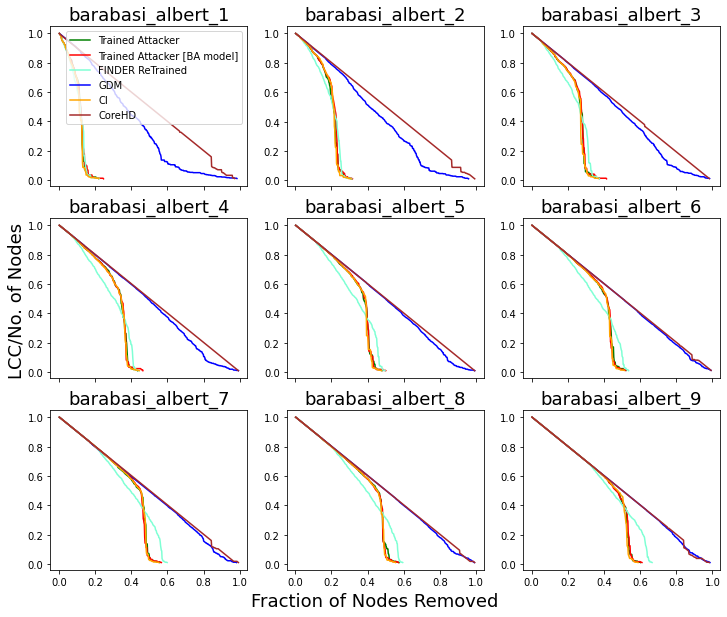

In [13]:
#BA 474500 #Homo 59000 #Hetero 348500#Tree 476000#
#BA 429000 # Homo 461500 #Hetero 5000 #Tree 1000 #
BA = 180000
MIX = 85000 
parameter = ["./utils/hyperparameters/BA/ba_params.json","./utils/hyperparameters/Mix/mixed_params.json"]
attacker= [BA,MIX]
graph_path= "./Dataset/SyntheticGraph/"
file_list =  ['barabasi_albert_1', 'barabasi_albert_2', 'barabasi_albert_3', 'barabasi_albert_4', 'barabasi_albert_5', 'barabasi_albert_6', 'barabasi_albert_7', 'barabasi_albert_8', 'barabasi_albert_9']
x, y = 3, 3
grid_plot = [[i,j] for i in range(x) for j in range(y)]
auc_BA, fraction_BA = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"ba",grid_plot,[x,y])

## ER Graph

erdos_renyi_3 ,erdos_renyi_4 ,erdos_renyi_5 ,erdos_renyi_6 ,erdos_renyi_7 ,erdos_renyi_8 ,


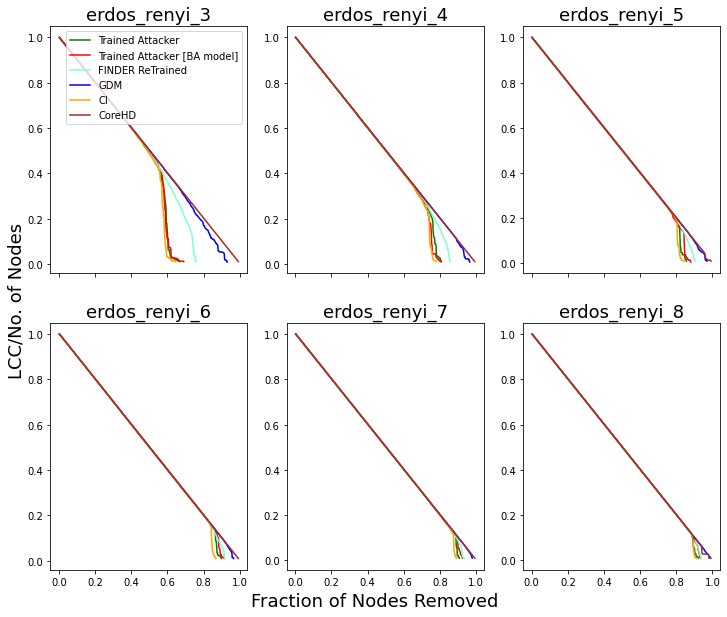

In [19]:
#BA 474500 #Homo 59000 #Hetero 348500#Tree 476000#
#BA 429000 # Homo 461500 #Hetero 5000 #Tree 1000 #
BA = 295500
MIX = 212500 
parameter = ["./utils/hyperparameters/BA/ba_params.json","./utils/hyperparameters/Mix/mixed_params.json"]
attacker= [BA,MIX]
graph_path= "./Dataset/SyntheticGraph/"
file_list =  ['erdos_renyi_3','erdos_renyi_4','erdos_renyi_5','erdos_renyi_6','erdos_renyi_7','erdos_renyi_8']
x, y = 2, 3
grid_plot = [[i,j] for i in range(x) for j in range(y)]
auc_ER, fraction_ER = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"er",grid_plot,[x,y])


## SW Graph

small-world_0 ,small-world_1 ,small-world_2 ,small-world_3 ,small-world_4 ,small-world_5 ,small-world_6 ,small-world_7 ,small-world_8 ,


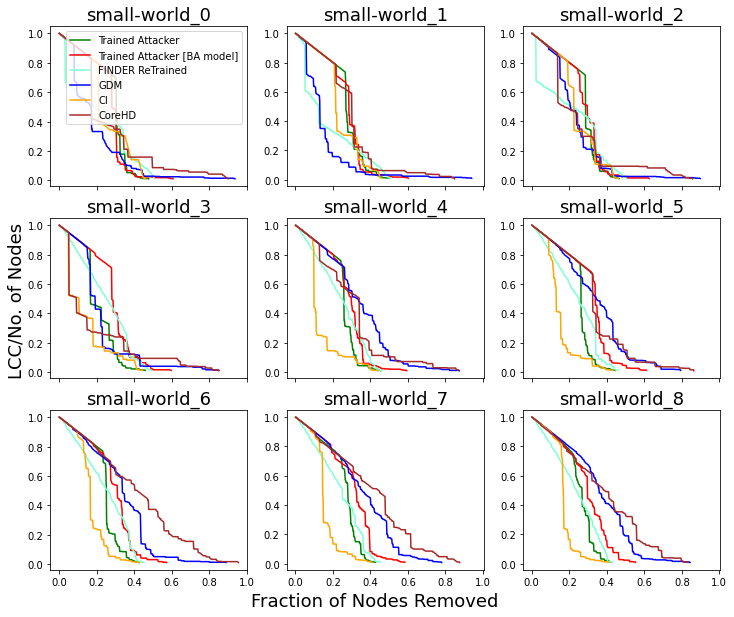

In [20]:
#BA 474500 #Homo 59000 #Hetero 348500#Tree 476000#
#BA 429000 # Homo 461500 #Hetero 5000 #Tree 1000 #
BA = 232000
MIX = 85000 
parameter = ["./utils/hyperparameters/BA/ba_params.json","./utils/hyperparameters/Mix/mixed_params.json"]
attacker= [BA,MIX]
graph_path= "./Dataset/SyntheticGraph/"
file_list =  ['small-world_0','small-world_1','small-world_2','small-world_3','small-world_4','small-world_5','small-world_6','small-world_7','small-world_8']
x, y = 3, 3
grid_plot = [[i,j] for i in range(x) for j in range(y)]
auc_SW, fraction_SW = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"sw",grid_plot,[x,y])


# Synthetic with Motifs Attached

## BA

ba_300_20_house_1 ,ba_300_40_house_2 ,ba_300_60_house_3 ,ba_300_80_house_4 ,ba_300_100_house_5 ,ba_300_20_fan_1 ,ba_300_40_fan_2 ,ba_300_60_fan_3 ,ba_300_80_fan_4 ,ba_300_100_fan_5 ,ba_300_20_clique_1 ,ba_300_40_clique_2 ,ba_300_60_clique_3 ,ba_300_80_clique_4 ,ba_300_100_clique_5 ,ba_300_20_diamond_1 ,ba_300_40_diamond_2 ,ba_300_60_diamond_3 ,ba_300_80_diamond_4 ,ba_300_100_diamond_5 ,ba_300_20_cycle_1 ,ba_300_40_cycle_2 ,ba_300_60_cycle_3 ,ba_300_80_cycle_4 ,ba_300_20_star_1 ,ba_300_40_star_2 ,ba_300_60_star_3 ,ba_300_80_star_4 ,ba_300_100_star_5 ,ba_300_20_grid_1 ,ba_300_40_grid_2 ,ba_300_60_grid_3 ,ba_300_80_grid_4 ,ba_300_100_grid_5 ,


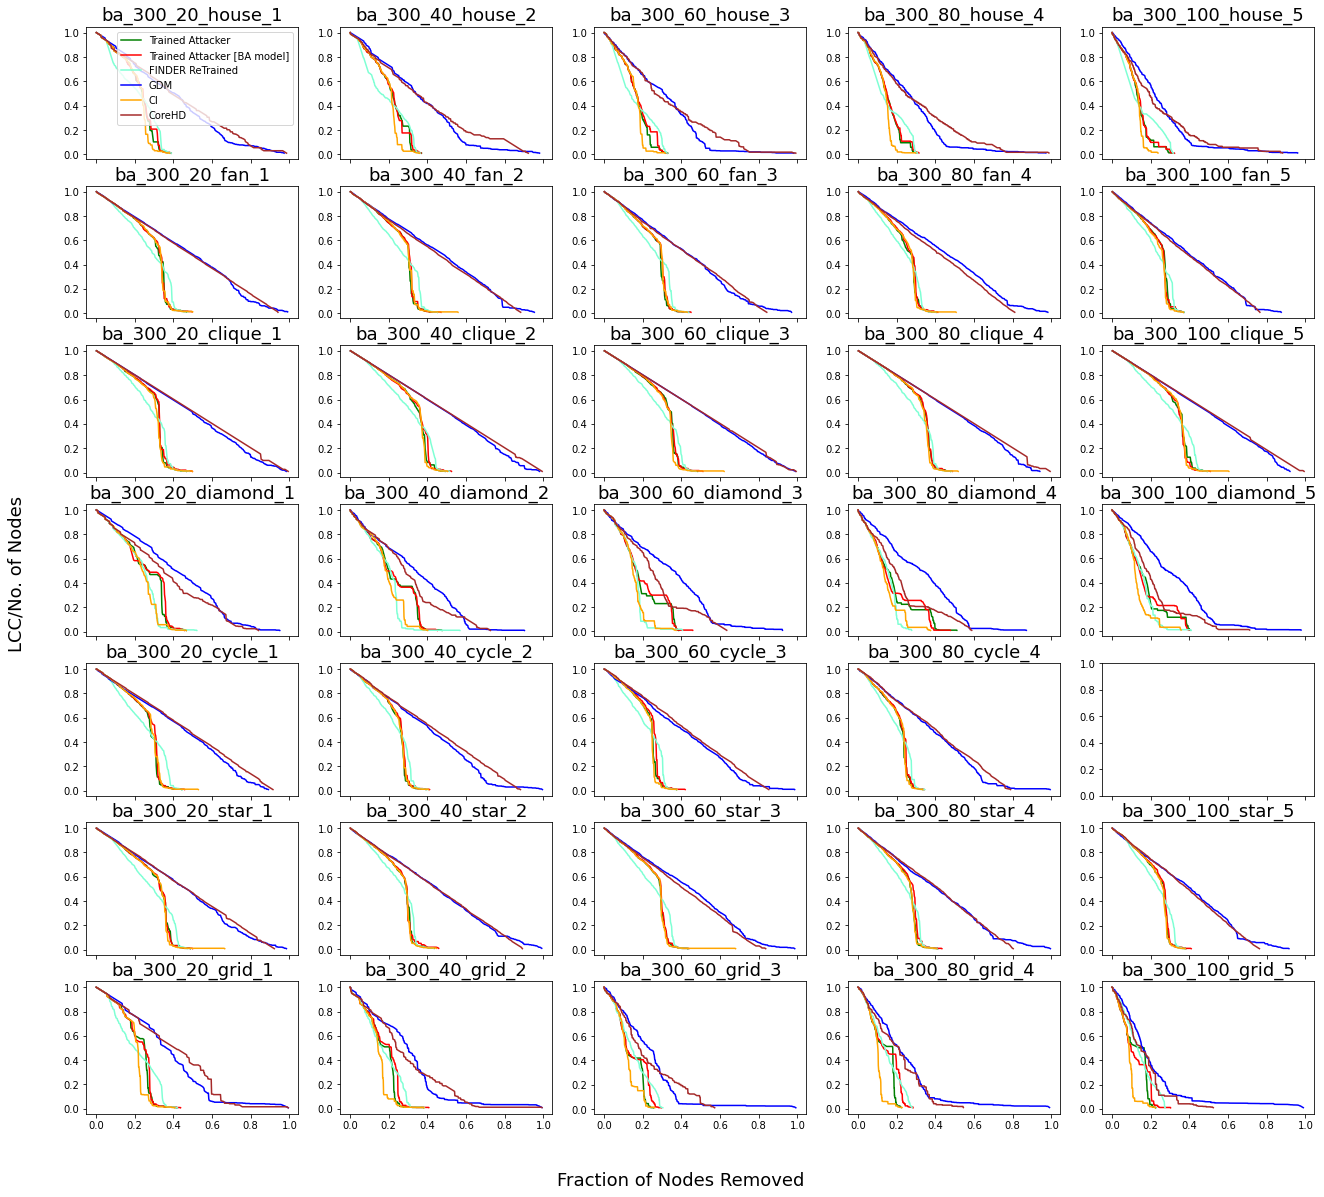

In [9]:
BA = 178000
MIX = 123000 
parameter = ["./utils/hyperparameters/BA/ba_params.json","./utils/hyperparameters/Mix/mixed_params.json"]
attacker= [BA,MIX]
file_list = ['ba_300_20_house_1', 'ba_300_40_house_2', 'ba_300_60_house_3', 'ba_300_80_house_4', 'ba_300_100_house_5', 'ba_300_20_fan_1', 'ba_300_40_fan_2', 'ba_300_60_fan_3', 'ba_300_80_fan_4', 'ba_300_100_fan_5', 'ba_300_20_clique_1', 'ba_300_40_clique_2', 'ba_300_60_clique_3', 'ba_300_80_clique_4', 'ba_300_100_clique_5', 'ba_300_20_diamond_1', 'ba_300_40_diamond_2', 'ba_300_60_diamond_3', 'ba_300_80_diamond_4', 'ba_300_100_diamond_5', 'ba_300_20_cycle_1', 'ba_300_40_cycle_2', 'ba_300_60_cycle_3', 'ba_300_80_cycle_4','ba_300_20_star_1', 'ba_300_40_star_2', 'ba_300_60_star_3', 'ba_300_80_star_4', 'ba_300_100_star_5', 'ba_300_20_grid_1', 'ba_300_40_grid_2', 'ba_300_60_grid_3', 'ba_300_80_grid_4', 'ba_300_100_grid_5']
graph_path = "./Dataset/Validation/Motifs_Attached/BA/"
x, y = 7, 5
grid_plot = [[i,j] for i in range(x) for j in range(y)]
grid_plot.pop((5*5 -1))
auc_BA_Motif, fraction_BA_Motif = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"BA_Motifs",grid_plot,[x,y])


## Tree

tree_8_20_house_1 ,tree_8_40_house_2 ,tree_8_60_house_3 ,tree_8_80_house_4 ,tree_8_100_house_5 ,tree_8_20_fan_1 ,tree_8_40_fan_2 ,tree_8_60_fan_3 ,tree_8_80_fan_4 ,tree_8_100_fan_5 ,tree_8_20_clique_1 ,tree_8_40_clique_2 ,tree_8_60_clique_3 ,tree_8_80_clique_4 ,tree_8_100_clique_5 ,tree_8_20_diamond_1 ,tree_8_40_diamond_2 ,tree_8_60_diamond_3 ,tree_8_80_diamond_4 ,tree_8_100_diamond_5 ,tree_8_20_cycle_1 ,tree_8_40_cycle_2 ,tree_8_60_cycle_3 ,tree_8_80_cycle_4 ,tree_8_100_cycle_5 ,tree_8_20_star_1 ,tree_8_40_star_2 ,tree_8_60_star_3 ,tree_8_80_star_4 ,tree_8_100_star_5 ,tree_8_20_grid_1 ,tree_8_40_grid_2 ,tree_8_60_grid_3 ,tree_8_80_grid_4 ,tree_8_100_grid_5 ,


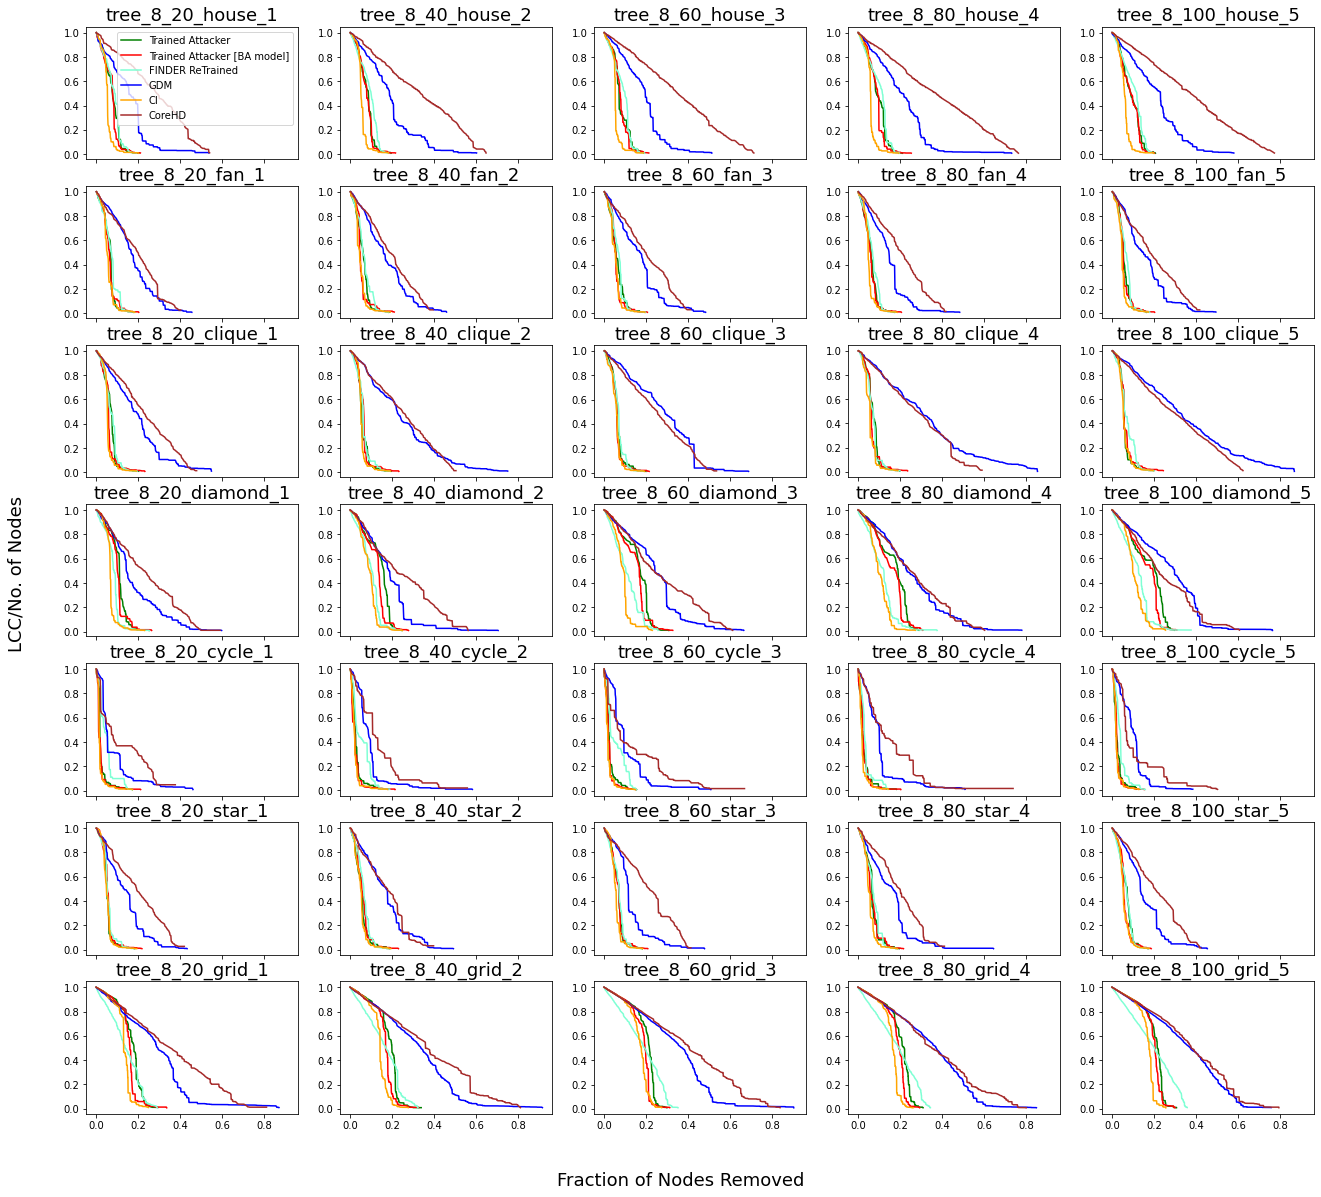

In [10]:
BA = 18000
MIX = 140500  
parameter = ["./utils/hyperparameters/BA/ba_params.json","./utils/hyperparameters/Mix/mixed_params.json"]
attacker= [BA,MIX]
file_list = ['tree_8_20_house_1', 'tree_8_40_house_2', 'tree_8_60_house_3', 'tree_8_80_house_4', 'tree_8_100_house_5', 'tree_8_20_fan_1', 'tree_8_40_fan_2', 'tree_8_60_fan_3', 'tree_8_80_fan_4', 'tree_8_100_fan_5', 'tree_8_20_clique_1', 'tree_8_40_clique_2', 'tree_8_60_clique_3', 'tree_8_80_clique_4', 'tree_8_100_clique_5', 'tree_8_20_diamond_1', 'tree_8_40_diamond_2', 'tree_8_60_diamond_3', 'tree_8_80_diamond_4', 'tree_8_100_diamond_5', 'tree_8_20_cycle_1', 'tree_8_40_cycle_2', 'tree_8_60_cycle_3', 'tree_8_80_cycle_4', 'tree_8_100_cycle_5', 'tree_8_20_star_1', 'tree_8_40_star_2', 'tree_8_60_star_3', 'tree_8_80_star_4', 'tree_8_100_star_5', 'tree_8_20_grid_1', 'tree_8_40_grid_2', 'tree_8_60_grid_3','tree_8_80_grid_4', 'tree_8_100_grid_5']
graph_path ="./Dataset/Validation/Motifs_Attached/Tree/" 
x, y = 7, 5
grid_plot = [[i,j] for i in range(x) for j in range(y)]
#[print(i,file_list[i],grid_plot[i][0],grid_plot[i][1]) for i in range(x*y)]
auc_Tree_Motif, fraction_Tree_Motif = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"Tree_Motifs",grid_plot,[x,y])


# Real World Dataset

corruption ,foodweb-baywet ,inf-USAir97 ,moreno_crime_projected ,household ,faa ,facebook ,powergrid ,netscience ,

/home/bhandk/AttackandDefend/utils/environment/envhelper.py:166: RuntimeWarning: ARPACK solver failed to converge (3001 iterations, 0/1 eigenvectors converged) at src/linalg/arpack.c:821
  eigen_centrality = np.array(g.eigenvector_centrality())


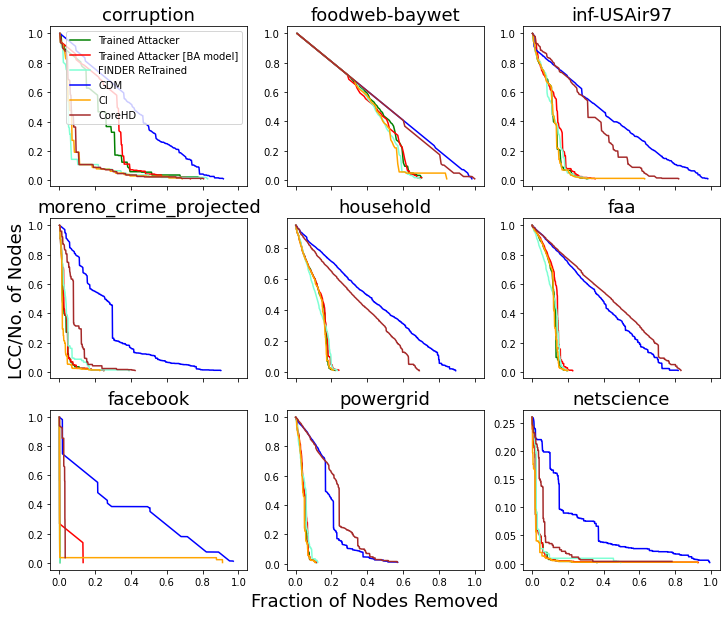

In [237]:
BA = 18000
MIX = 140500  
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/TS/Older Model/BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/TS/Older Model/Mix_Graph/model_differentGraph_'+str(MIX))]
file_list = ["corruption","foodweb-baywet","inf-USAir97","moreno_crime_projected",'opsahl-openflights','household','faa','facebook','powergrid','netscience','HI-II-14']
file_list = ["corruption","foodweb-baywet","inf-USAir97","moreno_crime_projected",'household','faa','facebook','powergrid','netscience']
graph_path =  "./Dataset/Real/"
x, y = 3, 3
grid_plot = [[i,j] for i in range(x) for j in range(y)]
#[print(i,file_list[i],grid_plot[i][0],grid_plot[i][1]) for i in range(x*y)]
auc_real, fraction_real =visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"Real",grid_plot,[x,y])


## Cancer Gene

COAD ,HNSC ,KICH ,PRAD ,UCEC ,


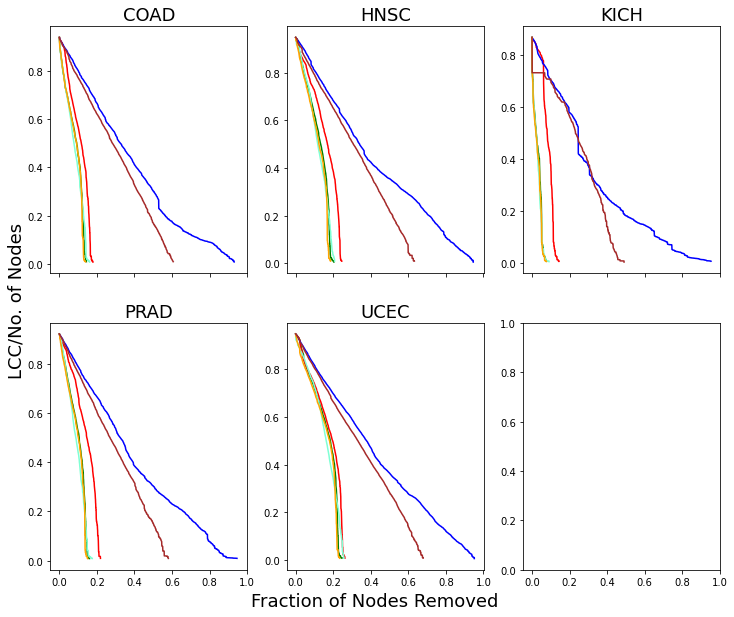

In [16]:
BA = 18000
MIX = 123000 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph_TS/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_TS/model_differentGraph_'+str(MIX))]

graph_path = "./Dataset/GeneNetwork/"
file_list =  ["COAD","HNSC","KICH","PRAD","UCEC"]
x, y = 2, 3
grid_plot = [[i,j] for i in range(x) for j in range(y)]
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"Cancer_Gene",grid_plot,[x,y])

In [ ]:
import json
def get_from_json(file_path):
    with open(file_path) as json_file:
        data = json.load(json_file)
    return data
#https://bobbyhadz.com/blog/python-typeerror-object-of-type-ndarray-is-not-json-serializable
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
'''color = ['Green','Red','Aquamarine','Blue','Orange','Brown']
for a in [auc_BA,auc_ER,auc_SW,auc_BA_Motif,auc_Tree_Motif]:
    for i, key in enumerate(a):
        a[key]['color']= color[i]
for a in [fraction_BA,fraction_ER,fraction_SW,fraction_BA_Motif,fraction_Tree_Motif]:
    for i, key in enumerate(a):
        a[key]['color']= color[i]'''
graph_list = {}
graph_list["ba"] = {"graph":  ['barabasi_albert_30', 'barabasi_albert_50', 'barabasi_albert_100', 'barabasi_albert_250', 'barabasi_albert_500', 'barabasi_albert_750'],
                    "color":"red",
                    "auc" : auc_BA,
                    "fraction" : fraction_BA,
                    "title": "BA Graph with <k> ~ 6"
                   }
graph_list["er"] = {"graph": ['erdos_renyi_30', 'erdos_renyi_50', 'erdos_renyi_100', 'erdos_renyi_250', 'erdos_renyi_500', 'erdos_renyi_750'],
                    "color":"blue",
                    "auc" : auc_ER,
                    "fraction" : fraction_ER,
                    "title": "ER Graph with <k> ~ 6"
                   } 
graph_list["sw"] = {"graph" :  ['small-world_30', 'small-world_50', 'small-world_100', 'small-world_250', 'small-world_500', 'small-world_750'],
                    "color": "green",
                    "auc" : auc_SW,
                    "fraction" : fraction_SW,
                    "title": "SW Graph with <k> ~ 6"
                   }
graph_list["ba_motif"] = {"graph" : ['ba_300_20_house_1', 'ba_300_40_house_2', 'ba_300_60_house_3', 'ba_300_80_house_4', 'ba_300_100_house_5', 'ba_300_20_fan_1', 'ba_300_40_fan_2', 'ba_300_60_fan_3', 'ba_300_80_fan_4', 'ba_300_100_fan_5', 'ba_300_20_clique_1', 'ba_300_40_clique_2', 'ba_300_60_clique_3', 'ba_300_80_clique_4', 'ba_300_100_clique_5', 'ba_300_20_diamond_1', 'ba_300_40_diamond_2', 'ba_300_60_diamond_3', 'ba_300_80_diamond_4', 'ba_300_100_diamond_5', 'ba_300_20_cycle_1', 'ba_300_40_cycle_2', 'ba_300_60_cycle_3', 'ba_300_80_cycle_4','ba_300_20_star_1', 'ba_300_40_star_2', 'ba_300_60_star_3', 'ba_300_80_star_4', 'ba_300_100_star_5', 'ba_300_20_grid_1', 'ba_300_40_grid_2', 'ba_300_60_grid_3', 'ba_300_80_grid_4', 'ba_300_100_grid_5'],
                    "color":"brown",
                    "auc" : auc_BA_Motif,
                    "fraction" : fraction_BA_Motif,
                    "title": "BA Graph with Motifs"
                    }
graph_list["tree_motif"] = {"graph": ['tree_8_20_house_1', 'tree_8_40_house_2', 'tree_8_60_house_3', 'tree_8_80_house_4', 'tree_8_100_house_5', 'tree_8_20_fan_1', 'tree_8_40_fan_2', 'tree_8_60_fan_3', 'tree_8_80_fan_4', 'tree_8_100_fan_5', 'tree_8_20_clique_1', 'tree_8_40_clique_2', 'tree_8_60_clique_3', 'tree_8_80_clique_4', 'tree_8_100_clique_5', 'tree_8_20_diamond_1', 'tree_8_40_diamond_2', 'tree_8_60_diamond_3', 'tree_8_80_diamond_4', 'tree_8_100_diamond_5', 'tree_8_20_cycle_1', 'tree_8_40_cycle_2', 'tree_8_60_cycle_3', 'tree_8_80_cycle_4', 'tree_8_100_cycle_5', 'tree_8_20_star_1', 'tree_8_40_star_2', 'tree_8_60_star_3', 'tree_8_80_star_4', 'tree_8_100_star_5', 'tree_8_20_grid_1', 'tree_8_40_grid_2', 'tree_8_60_grid_3','tree_8_80_grid_4', 'tree_8_100_grid_5'] ,
                    "color" : "yellow",
                    "auc" : auc_Tree_Motif,
                    "fraction" : fraction_Tree_Motif,
                    "title": "Tree Graph with Motifs"
                    }
graph_list["real"] = {"graph": ["corruption","foodweb-baywet","inf-USAir97","moreno_crime_projected",'household','faa','facebook','powergrid','netscience'],
                    "color" : "orange",
                    "auc" : auc_real,
                    "fraction" : fraction_real,
                    "title": "Real World Networks"
                    }
#feature = {"nodes", "edges", "heterogeneity", "density", "resilience", "modularity", "eccentricity", "diameter", "radius", "spectral_radius", "spectral_gap", "natural_connectivity", "global_efficiency", "assortativity"}
with open("./Figure/Compiled/HDA/Result.json", "w") as outfile:
    json.dump(graph_list, outfile, cls=NpEncoder)

In [31]:
import json
def get_from_json(file_path):
    with open(file_path) as json_file:
        data = json.load(json_file)
    return data
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
graph_list = get_from_json("./Figure/Compiled/HDA/Result.json")
graph_list["ba"] = {"graph":  ['barabasi_albert_1', 'barabasi_albert_2', 'barabasi_albert_3', 'barabasi_albert_4', 'barabasi_albert_5', 'barabasi_albert_6', 'barabasi_albert_7', 'barabasi_albert_8', 'barabasi_albert_9'],
                    "color":"red",
                    "auc" : auc_BA,
                    "fraction" : fraction_BA,
                    "title": "BA Graph with <k> ~ 6"
                   }
graph_list["er"] = {"graph": ['erdos_renyi_3','erdos_renyi_4','erdos_renyi_5','erdos_renyi_6','erdos_renyi_7','erdos_renyi_8'],
                    "color":"blue",
                    "auc" : auc_ER,
                    "fraction" : fraction_ER,
                    "title": "ER Graph with <k> ~ 6"
                   } 
graph_list["sw"] = {"graph" :  ['small-world_0','small-world_1','small-world_2','small-world_3','small-world_4','small-world_5','small-world_6','small-world_7','small-world_8'],
                    "color": "green",
                    "auc" : auc_SW,
                    "fraction" : fraction_SW,
                    "title": "SW Graph with <k> ~ 6"
                   }
with open("./Figure/Compiled/HDA/Result.json", "w") as outfile:
    json.dump(graph_list, outfile, cls=NpEncoder)

{'ba': {'graph': ['barabasi_albert_30', 'barabasi_albert_50', 'barabasi_albert_100', 'barabasi_albert_250', 'barabasi_albert_500', 'barabasi_albert_750'], 'color': 'red', 'auc': {'barabasi_albert_30': [7.133333333333333, 7.066666666666666, 6.95, 8.083333333333332, 11.616666666666667, 14.983333333333334], 'barabasi_albert_50': [9.940000000000001, 10.14, 9.709999999999999, 10.83, 20.75, 24.990000000000002], 'barabasi_albert_100': [20.6, 20.669999999999998, 19.895, 21.965000000000007, 44.004999999999995, 49.544999999999995], 'barabasi_albert_250': [45.18, 45.964, 44.211999999999996, 45.84, 113.404, 123.896], 'barabasi_albert_500': [87.019, 88.178, 86.345, 87.489, 213.50899999999996, 246.03099999999998], 'barabasi_albert_750': [138.494, 141.47266666666667, 136.38733333333334, 135.27266666666668, 345.686, 373.45666666666665]}, 'fraction': {'barabasi_albert_30': [0.5, 0.5, 0.6, 1.0, 1.0, 1.0], 'barabasi_albert_50': [0.42, 0.42, 0.46, 1.0, 1.0, 1.0], 'barabasi_albert_100': [0.5, 0.52, 0.52, 0

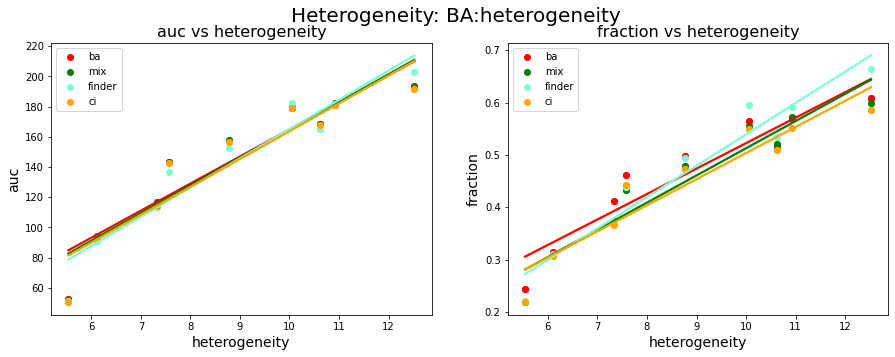

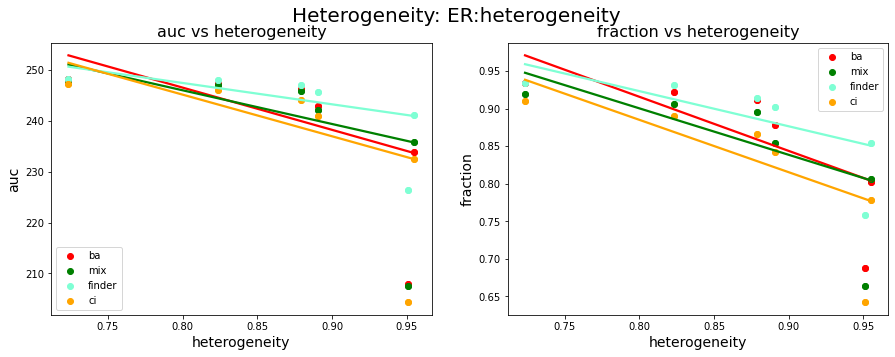

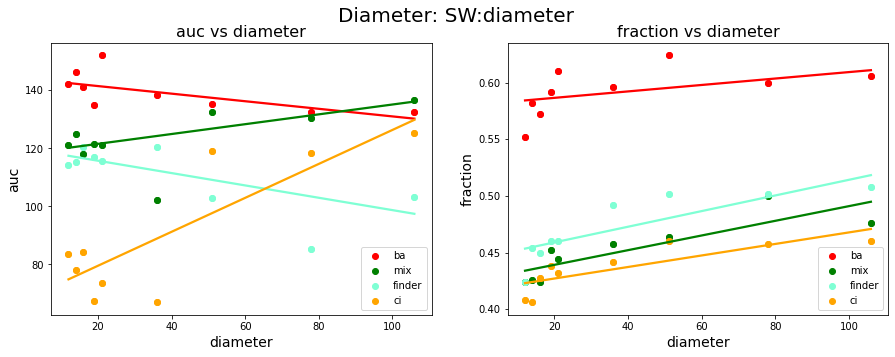

"for prop in properties:\n    title= 'TreeMotifs_BAMotifs_Grid'\n    scatter_plot(graph_list,['ba','mix','finder','ci'],[prop],title, graph_type_filters =['tree_motif','ba_motif'],graph_filter =['tree_8_20_grid_1', 'tree_8_40_grid_2', 'tree_8_60_grid_3','tree_8_80_grid_4', 'tree_8_100_grid_5','ba_300_20_grid_1', 'ba_300_40_grid_2', 'ba_300_60_grid_3', 'ba_300_80_grid_4', 'ba_300_100_grid_5'])  "

In [55]:
import json 
import seaborn as sns
# 
def get_from_json(file_path):
    with open(file_path) as json_file:
        data = json.load(json_file)
    return data
    
def get_data(list_graph,model,data, feature, prop):
    idx = {"mix" : 0,"ba" : 1,"finder" : 2,"ci" : 3,"gmd" : 4,"corehd" : 5}
    color = ['Green','Red','Aquamarine','Orange','Blue','Brown']
    x, y  = [], []
    for graph in list_graph:
        x.append(feature[graph][prop])
        y.append(data[graph][idx[model]])
    return x, y, color[idx[model]]
#all_graph_list = dictonary of all graph type with result of the evaluation from the model=> contains graphs, auc for all model, fraction of node removed for all model
#model_list = List of models for comparison
#feature_list = Lis of graph features/ properties to be considered for comparison
# filesave= filename to save the figure
#graph_type_fiter = List of graph types to filter only certain graphtype for comparison
#save = Boolean value to decide if to save the figure or not

def scatter_plot(all_graphtype_list, model_list,feature_list,filesave, graph_type_filters = None,graph_filter = [], save = False):
    if graph_type_filters != None:
        graphtype_list = {your_key: all_graphtype_list[your_key] for your_key in graph_type_filters}
    else:
        graphtype_list = all_graphtype_list
    graph_properties = get_from_json("./Dataset/features.json")
    data_type = ["auc","fraction"]
    fig, ax = plt.subplots(1,2,figsize=(15, 5))
    for i, data in enumerate(data_type):
        l ={}
        for j, model in enumerate(model_list):
            x_all_graph =y_all_graph = []
            for k, graph_type in enumerate(graphtype_list):
                if graph_filter == None:
                    graph_list = graphtype_list[graph_type]["graph"]
                else:
                    graph_list = set(graphtype_list[graph_type]["graph"]).intersection(graph_filter)
                for feature in feature_list:
                    x, y, color = get_data(graph_list,model,graphtype_list[graph_type][data], graph_properties, feature)
                    l[j] =ax[i].scatter(x, y, color = color,label = model)
                    x_all_graph= x_all_graph + x
                    y_all_graph= y_all_graph + y
                    ax[i].set_title((data+" vs "+'-'.join(feature_list)), fontsize=16)
            
            sns.regplot(x=x_all_graph, y=y_all_graph,ci=None, color = color,  ax= ax[i],robust=True) #
        ax[i].legend(l.values(),model_list)
        ax[i].set_ylabel(data, fontsize=14)
        ax[i].set_xlabel('-'.join(feature_list), fontsize=14)
    title = '-'.join(feature_list).capitalize() +": " +filesave
    fig.suptitle(title, fontsize=20)
    if save:
        plt.savefig("./Figure/Compiled/HDA/"+filesave)
    plt.show()
'''properties = ["heterogeneity"]
for prop in properties:
    title= "BA_ER_"+prop
    scatter_plot(graph_list,['ba','mix','finder','ci'],[prop],title, graph_type_filters =['ba','er']) 
properties = ["diameter", "assortativity"]
for prop in properties:
    title= "SW_"+prop
    scatter_plot(graph_list,['ba','mix','finder','ci'],[prop],title, graph_type_filters =['sw']) 
properties = ["heterogeneity", "diameter", "assortativity"]
for prop in properties:
    title= 'TreeMotifs_'+prop
    scatter_plot(graph_list,['ba','mix','finder','ci'],[prop],title, graph_type_filters =['tree_motif'])    
properties = ["heterogeneity", "diameter", "assortativity"]
for prop in properties:
    title= 'BA_Motifs_'+prop
    scatter_plot(graph_list,['ba','mix','finder','ci'],[prop],title, graph_type_filters =['ba_motif'])  '''
properties = ["heterogeneity"]
for prop in properties:
    title= "BA:"+prop
    scatter_plot(graph_list,['ba','mix','finder','ci'],[prop],title, graph_type_filters =['ba'],graph_filter=None,save =True)
for prop in properties:
    title= "ER:"+prop
    scatter_plot(graph_list,['ba','mix','finder','ci'],[prop],title, graph_type_filters =['er'],graph_filter=None,save =True)
properties = ["diameter"]
for prop in properties:
    title= "SW:"+prop
    scatter_plot(graph_list,['ba','mix','finder','ci'],[prop],title, graph_type_filters =['sw'],graph_filter=None,save =True) 
'''for prop in properties:
    title= 'TreeMotifs_BAMotifs_Grid'
    scatter_plot(graph_list,['ba','mix','finder','ci'],[prop],title, graph_type_filters =['tree_motif','ba_motif'],graph_filter =['tree_8_20_grid_1', 'tree_8_40_grid_2', 'tree_8_60_grid_3','tree_8_80_grid_4', 'tree_8_100_grid_5','ba_300_20_grid_1', 'ba_300_40_grid_2', 'ba_300_60_grid_3', 'ba_300_80_grid_4', 'ba_300_100_grid_5'])  '''